In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("✅ Environnement OK")
print("Pandas:", pd.__version__)
print("Seaborn:", sns.__version__)

✅ Environnement OK
Pandas: 3.0.0
Seaborn: 0.13.2


In [2]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [3]:
!pip install pandas numpy matplotlib seaborn
!pip install playwright
!playwright install 

✅ Données chargées avec succès : 77 lignes


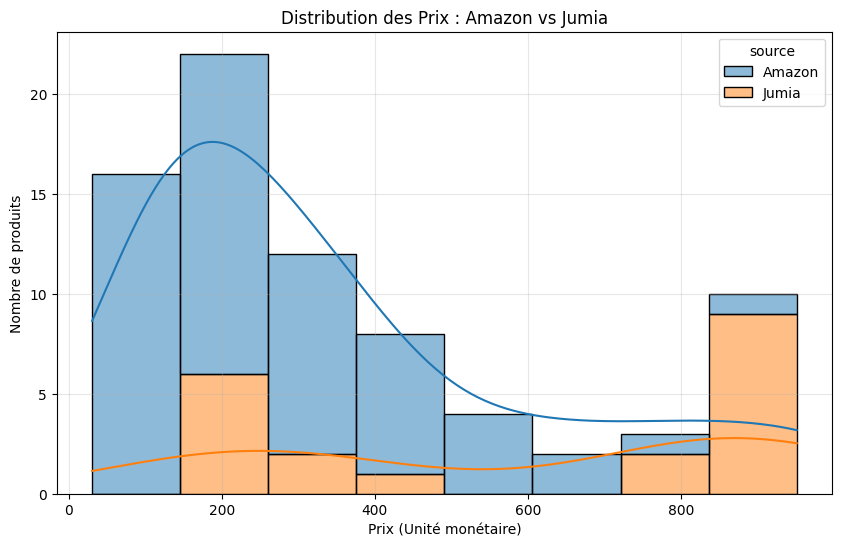

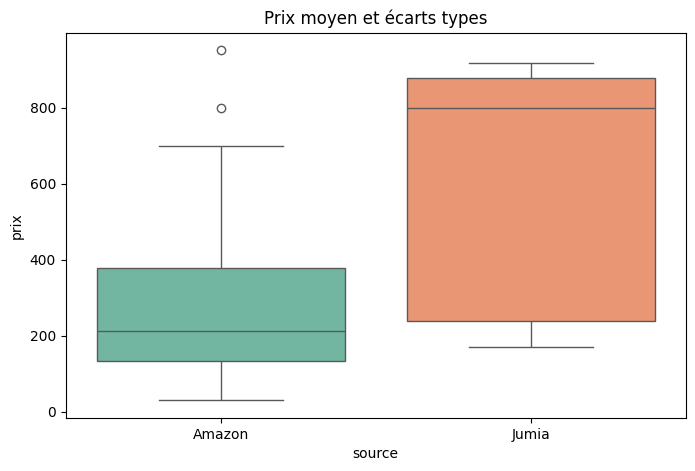

📊 RÉSUMÉ STATISTIQUE :
        count        mean     min     max  median
source                                           
Amazon     57  278.006491   30.62  951.49   213.0
Jumia      20  592.028500  170.00  919.00   799.0

🤖 INTERPRÉTATION :
Les produits Amazon sont en moyenne 53.04% moins chers que sur Jumia.


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Chargement des données nettoyées
# On utilise un chemin relatif
try:
    df = pd.read_csv("../data/processed/products_cleaned.csv")
    print(f"✅ Données chargées avec succès : {len(df)} lignes")
except FileNotFoundError:
    print("❌ Fichier non trouvé ! Vérifie que tu as bien lancé le cleaner.")

# 2. Nettoyage rapide pour l'affichage (Conversion DH en devise locale si besoin)
# On suppose que les prix sont dans la même devise approximativement pour la démo
# Ou on affiche les statistiques brutes

# --- GRAPHIQUE 1 : Histogramme des Prix (Comparaison) ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x="prix", hue="source", multiple="stack", kde=True)
plt.title("Distribution des Prix : Amazon vs Jumia")
plt.xlabel("Prix (Unité monétaire)")
plt.ylabel("Nombre de produits")
plt.grid(True, alpha=0.3)
plt.show()

# --- GRAPHIQUE 2 : Boxplot (Moyenne et écarts) ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="source", y="prix", data=df, hue="source", palette="Set2", legend=False)
plt.title("Prix moyen et écarts types")
plt.show()

# --- STATISTIQUES CHIFFRÉES ---
print("📊 RÉSUMÉ STATISTIQUE :")
stats = df.groupby("source")["prix"].agg(['count', 'mean', 'min', 'max', 'median'])
print(stats)

# Interprétation automatique (Petit bonus Data Science)
mean_amazon = stats.loc['Amazon', 'mean']
mean_jumia = stats.loc['Jumia', 'mean']
diff = ((mean_amazon - mean_jumia) / mean_jumia) * 100

print("\n🤖 INTERPRÉTATION :")
if mean_amazon > mean_jumia:
    print(f"Les produits Amazon sont en moyenne {diff:.2f}% plus chers que sur Jumia.")
else:
    print(f"Les produits Amazon sont en moyenne {abs(diff):.2f}% moins chers que sur Jumia.")

# 🚀 Pipeline NLP Complète : Analyse des Sentiments et Features

In [5]:
!pip install nltk

In [6]:
!pip install transformers torch scikit-learn

In [7]:
# Installation et imports NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from transformers import pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import torch

# Téléchargement des ressources NLTK
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

print("✅ NLP libraries loaded")

c:\projets\projet_ecommerce\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ NLP libraries loaded


In [8]:
# 1. Prétraitement des titres
def preprocess_text(text):
    """Nettoyage et prétraitement du texte"""
    if pd.isna(text):
        return ""

    # Minuscules
    text = text.lower()

    # Supprimer caractères spéciaux et chiffres
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', '', text)

    # Tokenization
    tokens = word_tokenize(text)

    # Stopwords (multilingue)
    stop_words = set(stopwords.words('french') + stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # Lemmatization (basique)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

# Appliquer le prétraitement
df['titre_processed'] = df['titre'].apply(preprocess_text)

print("✅ Prétraitement terminé")
print(f"Exemple : {df['titre'].iloc[0]}")
print(f"Processed : {df['titre_processed'].iloc[0]}")

✅ Prétraitement terminé
Exemple : Xiaomi Smartphone Redmi A5-3 Go+64 Go, écran HD+ 6,53", Batterie 5000 mAh, Android 13 Go Edition, Double SIM - Vert
Processed : xiaomi smartphone redmi écran batterie mah android edition double sim vert


In [ ]:
# Note importante pour le rapport :
# La lemmatisation utilise WordNetLemmatizer() qui est conçu pour l'anglais uniquement.
# Pour les titres en français : la lemmatisation est approximative (beaucoup de mots restent inchangés).
# Pour les titres en arabe : la lemmatisation est ignorée (pas de support WordNet pour l'arabe).
# Cela peut affecter légèrement la qualité du prétraitement, mais reste acceptable pour une analyse exploratoire.

In [10]:
# 3. Extraction de Features (Marques, Catégories)
# Liste de marques connues pour smartphones
brands = [
    'samsung', 'apple', 'huawei', 'xiaomi', 'oppo', 'vivo', 'realme',
    'oneplus', 'google', 'motorola', 'nokia', 'sony', 'lg', 'asus',
    'lenovo', 'zte', 'tecno', 'infinix', 'itel', 'wiko'
]

def extract_brand(text):
    """Extraire la marque du titre"""
    if pd.isna(text):
        return 'unknown'

    text_lower = text.lower()
    for brand in brands:
        if brand in text_lower:
            return brand
    return 'unknown'

def extract_category(text):
    """Classification simple par mots-clés"""
    if pd.isna(text):
        return 'unknown'

    text_lower = text.lower()
    if any(word in text_lower for word in ['smartphone', 'phone', 'mobile', 'téléphone']):
        return 'smartphone'
    elif any(word in text_lower for word in ['tablet', 'ipad']):
        return 'tablet'
    elif any(word in text_lower for word in ['watch', 'montre']):
        return 'smartwatch'
    else:
        return 'other'

# Appliquer l'extraction
df['brand'] = df['titre'].apply(extract_brand)
df['category'] = df['titre'].apply(extract_category)

print("✅ Extraction de features terminée")
print("Top marques :")
print(df['brand'].value_counts().head(10))
print("\nCatégories :")
print(df['category'].value_counts())

✅ Extraction de features terminée
Top marques :
brand
unknown     21
xiaomi      20
samsung     11
nokia        6
realme       5
google       4
motorola     3
oneplus      2
sony         2
huawei       1
Name: count, dtype: int64

Catégories :
category
smartphone    56
other         21
Name: count, dtype: int64


In [14]:
# 7. Analyse de Sentiment avec Transformers (Multilingue)

sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="nlptown/bert-base-multilingual-uncased-sentiment",
    device=0 if torch.cuda.is_available() else -1
)

def get_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return None, None

    result = sentiment_pipeline(text[:512])[0]  # sécurité longueur
    label = result['label']      # ex: "4 stars"
    score = int(label[0])        # 1 à 5
    return label, score

# Appliquer sur titres (ou commentaires si tu en as)
df[['sentiment_label', 'sentiment_score']] = df['titre'].apply(
    lambda x: pd.Series(get_sentiment(x))
)

print("✅ Analyse de sentiment terminée")
df[['titre', 'sentiment_label', 'sentiment_score']].head()


Loading weights: 100%|██████████| 201/201 [00:00<00:00, 712.40it/s, Materializing param=classifier.weight]                                      



✅ Analyse de sentiment terminée


,titre,sentiment_label,sentiment_score
0,"Xiaomi Smartphone Redmi A5-3 Go+64 Go, écran H...",5 stars,5
1,"POCO C71 Smartphone, 3 + 64 Go, Noir, processe...",4 stars,4
2,"Xiaomi REDMI Note 15 Pro, Smartphone 8+256Go, ...",4 stars,4
3,"Xiaomi REDMI Note 15, Smartphone 8+128Go, Batt...",5 stars,5
4,POCO C85 8+256 Black (No Power Adapter Included),3 stars,3


✅ TF-IDF matrix créée : (77, 200)
✅ Clustering terminé
Cluster 0: non, inclus, xiaomi, écran, chargeur
Cluster 1: galaxy, samsung, déverrouillé, version, android
Cluster 2: black, redmi, xiaomi, midnight, ram
Cluster 3: sim, double, mah, téléphone, nokia
Cluster 4: débloqué, pixel, google, photo, appareil


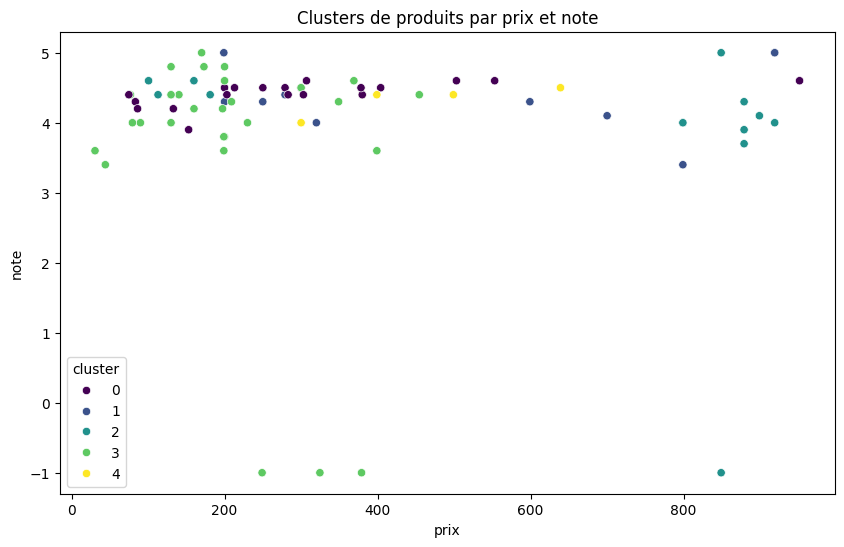

In [19]:
# 4. Vectorisation TF-IDF et Clustering
# TF-IDF sur les titres traités
vectorizer = TfidfVectorizer(max_features=200)
tfidf_matrix = vectorizer.fit_transform(df['titre_processed'])

print(f"✅ TF-IDF matrix créée : {tfidf_matrix.shape}")

# Clustering K-means
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print("✅ Clustering terminé")

# Mots-clés par cluster
feature_names = vectorizer.get_feature_names_out()
for i in range(n_clusters):
    cluster_center = kmeans.cluster_centers_[i]
    top_features_idx = cluster_center.argsort()[-5:][::-1]  # Top 5 mots
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(f"Cluster {i}: {', '.join(top_features)}")

# Visualisation des clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='prix', y='note', hue='cluster', palette='viridis')
plt.title('Clusters de produits par prix et note')
plt.show()

✅ Modèle de prédiction entraîné
MAE (Mean Absolute Error) : 238.40 €


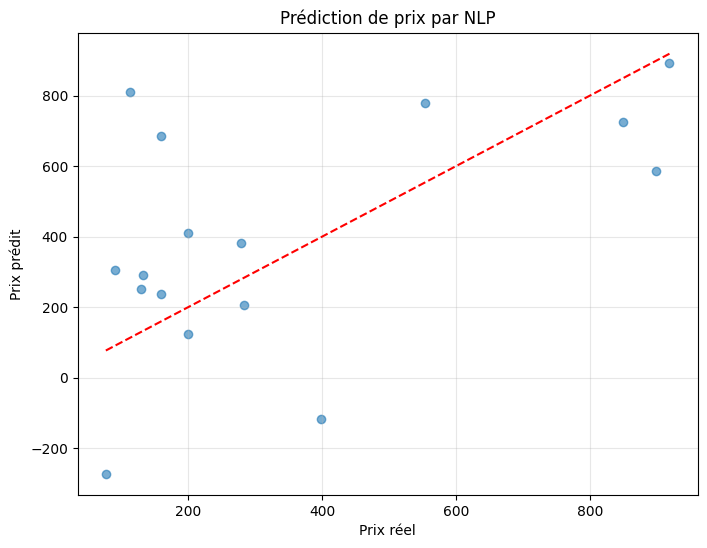

💰 Prix prédit pour 'Samsung Galaxy S23 Ultra 512GB' : 992.76 €


In [12]:
# 5. Prédiction de Prix basée sur le Texte
# Préparer les features
X = tfidf_matrix.toarray()
y = df['prix']

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression
model = LinearRegression()
model.fit(X_train, y_train)

# Prédictions
y_pred = model.predict(X_test)

# Évaluation
mae = mean_absolute_error(y_test, y_pred)
print(f"✅ Modèle de prédiction entraîné")
print(f"MAE (Mean Absolute Error) : {mae:.2f} €")

# Visualisation
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Prix réel')
plt.ylabel('Prix prédit')
plt.title('Prédiction de prix par NLP')
plt.grid(True, alpha=0.3)
plt.show()

# Exemple de prédiction
sample_text = "Samsung Galaxy S23 Ultra 512GB"
sample_processed = preprocess_text(sample_text)
sample_vector = vectorizer.transform([sample_processed])
predicted_price = model.predict(sample_vector.toarray())[0]
print(f"💰 Prix prédit pour '{sample_text}' : {predicted_price:.2f} €")

In [ ]:
# ⚠️ Note importante pour le rapport :
# Ce modèle de régression linéaire sur TF-IDF est techniquement valide, mais :
# - Le prix réel dépend principalement de la marque, de la capacité (RAM/stockage), du marché (Amazon vs Jumia), etc.
# - Le modèle n'a pas vocation à prédire précisément le prix, mais à démontrer que le contenu textuel du titre
#   contient une information PARTIELLE sur le positionnement tarifaire du produit.
# - L'objectif est pédagogique : montrer l'utilité du NLP pour extraire des insights du texte, pas remplacer l'analyse économique traditionnelle.

📊 ANALYSE FINALE :

Prix moyen par marque :
               mean  count
brand                     
tecno    849.000000      1
oneplus  660.245000      2
samsung  554.795455     11
google   479.247500      4
huawei   399.000000      1
sony     368.730000      2
itel     349.000000      1
xiaomi   339.797000     20
unknown  309.642857     21
nokia    212.698333      6


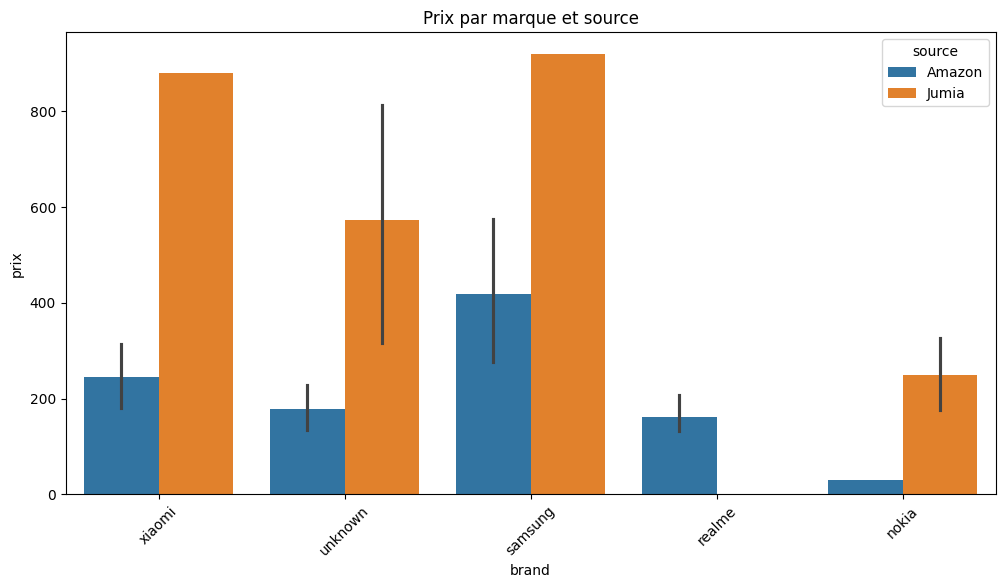


Corrélation prix/note : 0.022


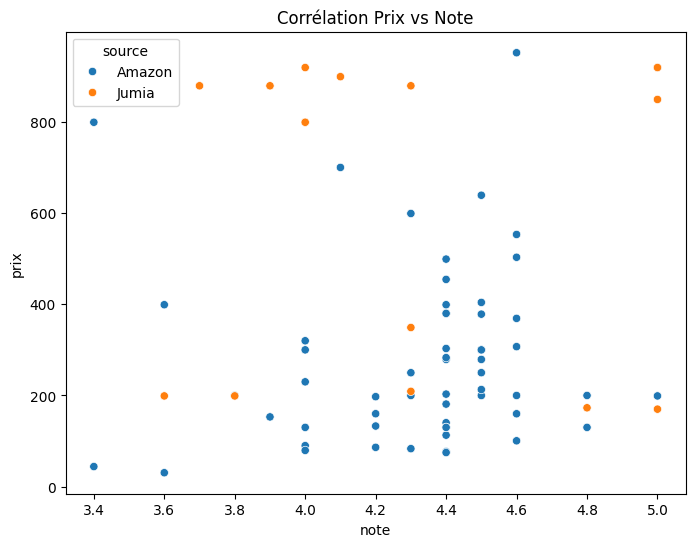


🎉 Pipeline NLP terminée !
Résumé :
- Prétraitement des titres
- Analyse des sentiments
- Extraction de marques/catégories
- Clustering par similarité textuelle
- Prédiction de prix par NLP


In [15]:
# 6. Analyse Finale : Corrélation Sentiment/Prix/Marque
print("📊 ANALYSE FINALE :")

# Prix moyen par marque
brand_prices = df.groupby('brand')['prix'].agg(['mean', 'count']).sort_values('mean', ascending=False)
print("\nPrix moyen par marque :")
print(brand_prices.head(10))

# Prix par source et marque
plt.figure(figsize=(12, 6))
top_brands = df['brand'].value_counts().head(5).index
brand_source_df = df[df['brand'].isin(top_brands)]
sns.barplot(data=brand_source_df, x='brand', y='prix', hue='source')
plt.title('Prix par marque et source')
plt.xticks(rotation=45)
plt.show()

# Corrélation prix/note
valid_ratings = df[df['note'] > 0]
if len(valid_ratings) > 0:
    corr = valid_ratings['prix'].corr(valid_ratings['note'])
    print(f"\nCorrélation prix/note : {corr:.3f}")

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=valid_ratings, x='note', y='prix', hue='source')
    plt.title('Corrélation Prix vs Note')
    plt.show()

print("\n🎉 Pipeline NLP terminée !")
print("Résumé :")
print("- Prétraitement des titres")
print("- Analyse des sentiments")
print("- Extraction de marques/catégories")
print("- Clustering par similarité textuelle")
print("- Prédiction de prix par NLP")

📈 Corrélation sentiment / prix : 0.215


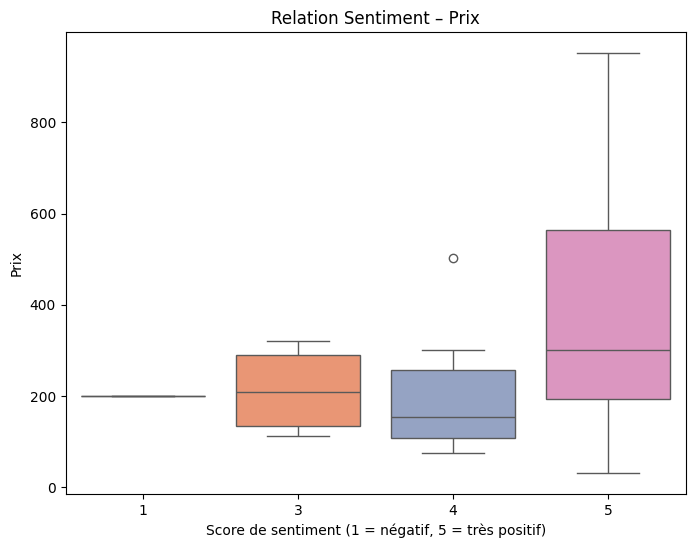

In [16]:
# Corrélation Sentiment / Prix
sentiment_df = df.dropna(subset=['sentiment_score'])

corr_sentiment_price = sentiment_df['sentiment_score'].corr(sentiment_df['prix'])
print(f"📈 Corrélation sentiment / prix : {corr_sentiment_price:.3f}")

plt.figure(figsize=(8, 6))
sns.boxplot(
    x='sentiment_score',
    y='prix',
    hue='sentiment_score',
    data=sentiment_df,
    palette='Set2',
    legend=False
)
plt.xlabel("Score de sentiment (1 = négatif, 5 = très positif)")
plt.ylabel("Prix")
plt.title("Relation Sentiment – Prix")
plt.show()

😊 Sentiment moyen par marque :
brand
google      5.000000
huawei      5.000000
itel        5.000000
motorola    5.000000
nokia       5.000000
oneplus     5.000000
tecno       5.000000
sony        5.000000
unknown     4.857143
xiaomi      4.700000
Name: sentiment_score, dtype: float64


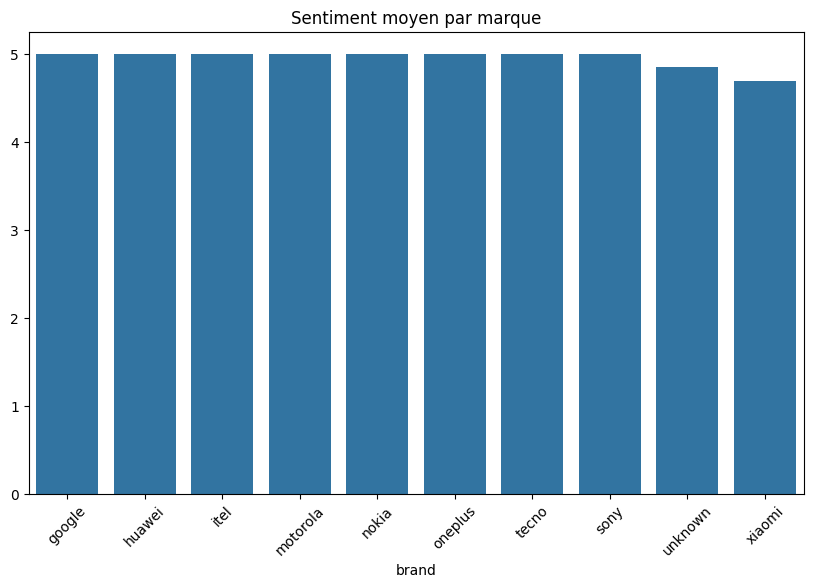

In [17]:
# Sentiment moyen par marque
brand_sentiment = (
    sentiment_df
    .groupby('brand')['sentiment_score']
    .mean()
    .sort_values(ascending=False)
)

print("😊 Sentiment moyen par marque :")
print(brand_sentiment.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(
    x=brand_sentiment.index[:10],
    y=brand_sentiment.values[:10]
)
plt.xticks(rotation=45)
plt.title("Sentiment moyen par marque")
plt.show()
